In [12]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import os, urllib, tarfile


本文主要介绍了模型训练中的各方面内容，包括模型构建、loss、优化器、metrics、正则化、学习率、激活函数、epochs、参数初始化、超参数搜索等。



## 1、模型训练
sklearn使用numpy ndarray或者pandas dataframe作为训练数据，调用fit()函数即可完成训练。

### 1.1 二分类

我们先看一个二分类问题，将mnist分类成数字5和非5两类：

In [23]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X,y = mnist['data'], mnist['target']

X_train, X_test = X[:6000], X[6000:]
y_train, y_test = y[:6000].astype(np.uint8), y[6000:].astype(np.uint8)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss='hinge')
sgd_clf.fit(X_train, y_train_5)
print(sgd_clf.predict([X[0]]))

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_model, X_train, y_train_5, cv=3, scoring='accuracy')

[ True]


array([0.9585, 0.9585, 0.96  ])

### 1.2 回归

我们再看一个回归算法的示例，使用的是housing数据集，预测地区房产的中位数。

In [15]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_file = os.path.join(housing_path,'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_file)
    housing_tgz = tarfile.open(tgz_file)
    housing_tgz.extractall(path = housing_path) #解压文件
    housing_tgz.close()
    
# fetch_housing_data()

housing = pd.read_csv(os.path.join(HOUSING_PATH,'housing.csv'))

median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median,inplace=True)

housing_label = housing['median_house_value']
housing_feature = housing.drop(['median_house_value','ocean_proximity'], axis=1)

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_feature,housing_label)
print(model.intercept_, model.coef_)

-3570118.0614940603 [-4.26104026e+04 -4.24754782e+04  1.14445085e+03 -6.62091740e+00
  8.11609666e+01 -3.98732002e+01  7.93047225e+01  3.97522237e+04]


## 5、metrics

chpt3的二分类问题以及metrics； 综合示例4housing数据集回归算法的metric。

### 5.1 MSE

我们先看一下回归问题常用的均方根误差MSE。

In [22]:
from sklearn.metrics import mean_squared_error
housing_pred = lin_reg.predict(housing_feature)
lin_mse = mean_squared_error(housing_label, housing_pred)
print(np.sqrt(lin_mse))

69658.1903557702


### 5.2 交叉验证
使用sklearn提供的cross_val_score()，我们可以很方便的交叉验证模型效果。比如，我们看一下上面5和非5的线性分类器的准确率：

In [66]:
from sklearn.model_selection import cross_val_score, cross_val_predict
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.96 , 0.958, 0.964])

上述代码中，我们随机划分训练数据和测试数据，训练模型后计算准确率，并重复了3次。

### 5.3 准确率、精度、召回率、F1、AUC

下面我们主要看一下准确率、精度、召回率、F1、ROC/AUC等常用于二分类问题的metrics。

#### 准确率

In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
y_pred_5 = sgd_clf.predict(X_test)

accuracy_score(y_test_5, y_pred_5)

0.960390625

#### 混淆矩阵

In [40]:
confusion_matrix(y_test_5, y_pred_5)

array([[56924,  1277],
       [ 1258,  4541]])

#### 精度、召回率、F1

In [42]:
precision_score(y_test_5, y_pred_5)


0.7805087658989344

In [43]:
recall_score(y_test_5, y_pred_5)


0.7830660458699776

In [44]:
f1_score(y_test_5, y_pred_5)

0.7817853146251184

#### ROC & AUC

In [45]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_5, y_pred_5)

0.880562421055296

### 5.4 阈值衡量、ROC曲线

sklearn不允许对分类模型直接设置阈值，但是可以访问它用于预测的决策分数。不是调用分类器的predict()函数，而是调用decision_function()函数，这种方法返回每个实例的分数，然后就可以根据这些分数，使用任意阈值进行预测了。

我们先看个示例：

In [58]:
y_pred = sgd_clf.predict([X_test[11]])
print(y_pred)

y_score = sgd_clf.decision_function([X_test[11]])
print(y_score)

[ True]
[41983.59649976]


我们随机抽取了一个样本，其score=41983，而默认的阈值为0，所以预测结果为True。如果我们现在想提高精度（降低其召回率），那可以提高其阈值：

In [57]:
threshold = 50000
y_predict_t = (y_score > threshold)
print(y_predict_t)

[False]


#### 阈值选择

那怎么选取合适的阈值呢？

我们先使用cross_val_predict()获取决策分数而非预测结果；然后使用precision_recall_curve()计算所有可能阈值的精度和召回率；最后使用matplotlib绘制精度和召回率相对于阈值的函数组：

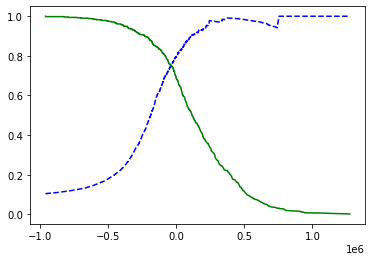

In [73]:
y_score = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_score)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

根据上图，可以选择合适的阈值。

假设你决定将精度设置为90%：

In [76]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
print(threshold_90_precision)

107733.64594126954


取的合适的阈值后，我们可以这样指定最终的预测结果：

In [79]:
y_pred_90 = (y_score >= threshold_90_precision)
print(y_pred_90)

[False False False ... False False False]


#### ROC曲线

画ROC曲线和上述的精度、召回率曲线类似，但要先算出FPR和TPR：

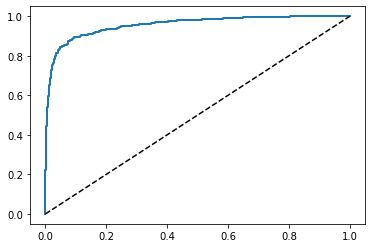

In [83]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_score)
def plt_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    
plt_roc_curve(fpr, tpr)
plt.show()

In [ ]:
画出ROC曲线后，可用

In [84]:
roc_auc_score(y_test_5, y_pred_5)

0.880562421055296